In [1]:
# import required libraries/dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential

In [2]:
train_path = r"D:\Research Internship\LaneDetection\tusimple_preprocessed\training"

In [3]:
# create a generator and get the images from the directory
img_generator = keras.preprocessing.image.ImageDataGenerator()
seed = 10
images_set = img_generator.flow_from_directory(
    train_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 320)
)

Found 7252 images belonging to 2 classes.


##### 

Actually, the images do not belong to two classes. Rather, there are two directories, one for images and one for their corresponding lane masks. So in the cell bellow, we handle it: seperate assign the images to X and y


In [ ]:
num_images = 7252 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0:
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 320)
    if i % 10 == 0:
        print(f'Batch {i}')

# convert the lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

In [ ]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [ ]:
# Normalize and reshape the mask set (Y)
Y = (Y >= 100).astype('int').reshape(-1, 256, 320, 1)

In [19]:
Y.min(), Y.max()

(0, 1)

In [20]:
# we get 1000 images for training and evaluation
X = np.array(X[:1000])
Y = np.array(Y[:1000])

In [21]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.1, random_state=100)


In [22]:

import gc
del X, Y, images_set
gc.collect()

23256

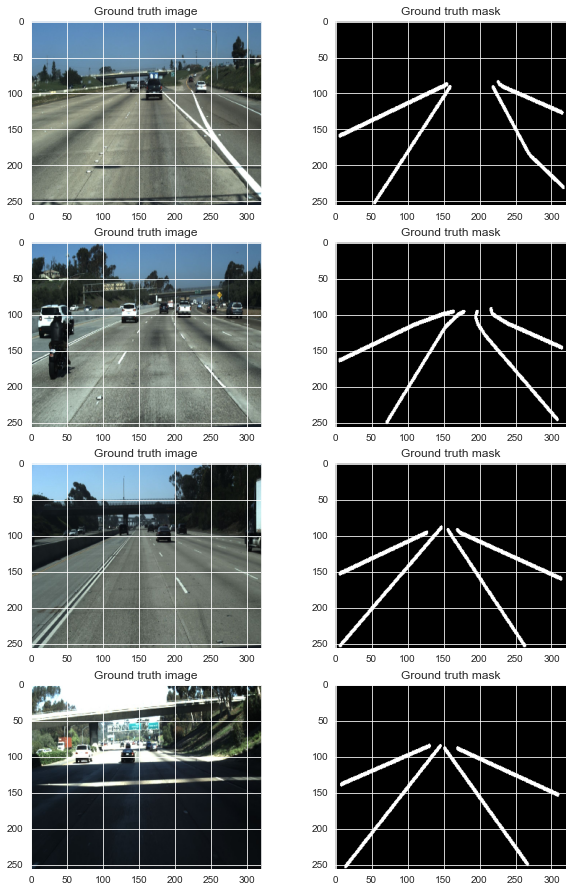

In [23]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Ground truth mask')
    index += 2

In [24]:
# define the model's architecture

from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_size=(256,320,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

model = unet()

In [25]:

# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 320, 64  1792        ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [31]:
# train the model
epochs = 10
batch_size = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val),
    batch_size=batch_size
)



Epoch 1/10
113/113 [==============================] - 1935s 17s/step - loss: 0.0930 - accuracy: 0.9492 - val_loss: 0.0391 - val_accuracy: 0.9595
Epoch 2/10
113/113 [==============================] - 1842s 16s/step - loss: 0.0361 - accuracy: 0.9600 - val_loss: 0.0400 - val_accuracy: 0.9594
Epoch 3/10
113/113 [==============================] - 1793s 16s/step - loss: 0.0258 - accuracy: 0.9654 - val_loss: 0.0197 - val_accuracy: 0.9706
Epoch 4/10
113/113 [==============================] - 1831s 16s/step - loss: 0.0198 - accuracy: 0.9707 - val_loss: 0.0158 - val_accuracy: 0.9749
Epoch 5/10
113/113 [==============================] - 1799s 16s/step - loss: 0.0171 - accuracy: 0.9737 - val_loss: 0.0146 - val_accuracy: 0.9764
Epoch 6/10
113/113 [==============================] - 1762s 16s/step - loss: 0.0155 - accuracy: 0.9758 - val_loss: 0.0141 - val_accuracy: 0.9776
Epoch 7/10
113/113 [==============================] - 1754s 16s/step - loss: 0.0147 - accuracy: 0.9767 - val_loss: 0.0138 - val_ac

In [27]:
model = keras.models.load_model("D:\Research Internship\LaneDetection\TF_UnetSimple\TF_UnetSimple.h5")

In [28]:
preds = model.predict(X_val)
preds.max(), preds.min()

4/4 [==============================] - 63s 13s/step


(0.9609469, 0.0)

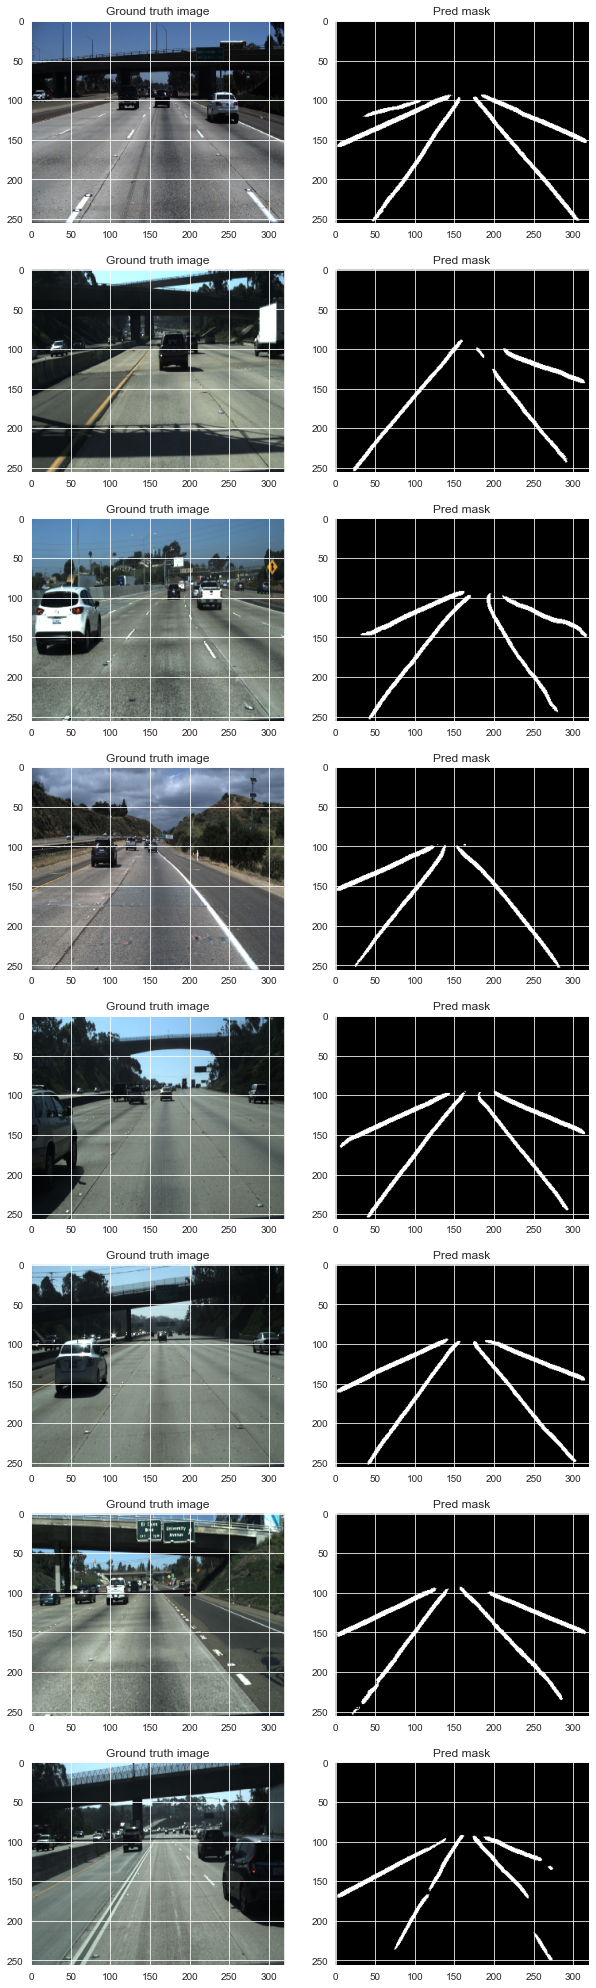

In [29]:
# visualize some results from the validation set.
plt.figure(figsize=(10, 45))
s, e = 90, 98
index = 1

preds = (preds >= .5).astype('int')
for i, j, k in zip(X_val[s:e], preds[s:e], Y_val[s:e]):

    # write these images into file as well
    cv2.imwrite(f'./out/img-{index}.jpg', i)
    cv2.imwrite(f'./out/pred-{index}.jpg', j*255.)
    cv2.imwrite(f'./out/ground-{index}.jpg', k*255.)

    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground truth image')

    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Pred mask')
    index += 2

In [30]:
# create metrices
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recal = tf.keras.metrics.Recall()
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])


# accuracy
accuracy.update_state(Y_val, preds)
accuracy_value = accuracy.result().numpy()
# precision
precision.update_state(Y_val, preds)
precision_value = precision.result().numpy()
# recal
recal.update_state(Y_val, preds)
recal_value = recal.result().numpy()
# f1 score
f1_score = 2 / ((1 / precision_value) + (1 / recal_value))

# Intersection over union (IoU)
iou.update_state(Y_val, preds)
iou_value = iou.result().numpy()

print("Accuracy:", accuracy_value)
print("Precision:", precision_value)
print("Recal:", recal_value)
print('F1 Score: ', f1_score)
print('IoU: ', iou_value)

Accuracy: 0.9792421
Precision: 0.7716346
Recal: 0.72899485
F1 Score:  0.7497089178007283
IoU:  0.59962755


In [36]:
model.save("D:\Research Internship\LaneDetection\TF_UnetSimple.h5")

In [31]:
import visualkeras
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

AttributeError: 'FreeTypeFont' object has no attribute 'getsize'